In [1]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
import pandas as pd
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch_geometric.nn import SAGEConv, global_mean_pool
from utils import get_feature_propagation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from Models.GAT import GATRegression
from Models.GraphSage import GraphSageRegression
from Models.Transformer import TransformerRegression
from Models.GATv2 import GATv2Regression
import matplotlib.pyplot as plt

In [2]:
data = torch.load('Data/santiago_zero_ismt.pt')
data.comuna = data.x[:, 8]
data.y = data.x[:,-2]
data.lat = data.x[:,0]
data.lon = data.x[:,1]
data.x = data.x[:, 2:8]
print(data)
print(data.x)
print(data.lat)
print(data.comuna)
print(data.y)
print(data.edge_index)
print(data.edge_attributes)

data.y = data.y.float()

Data(x=[337374, 6], edge_index=[2, 641693], edge_attributes=[641693, 2], comuna=[337374], y=[337374], lat=[337374], lon=[337374])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.5074, -1.1100, -1.6402,  1.2143,  1.6439,  1.6780],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
tensor([-33.4416, -33.4420, -33.4429,  ..., -33.4390, -33.4389, -33.4386])
tensor([39., 39., 39.,  ..., 42., 42., 42.])
tensor([0.0889, 0.0889, 0.1629,  ..., 0.1620, 0.1620, 0.1620])
tensor([[     0,      1,      2,  ..., 337372, 337373, 337373],
        [  4237,   4241,    480,  ..., 184408, 239479,   7705]])
tensor([[80.8500,  5.8000],
        [18.8300,  1.3000],
        [16.0600,  1.1000],
        ...,
        [33.0400,  4.1000],
        [ 2.5300,  0.2000],
       

In [4]:
data.x = get_feature_propagation(data)

Starting feature filling
tensor([[-1.8762,  0.0880,  1.8812, -0.7552, -2.0797, -1.2788],
        [ 0.2155, -0.1407, -0.2000,  0.7840,  0.9977,  0.7484],
        [ 0.0507, -1.1760, -0.3934,  1.3322,  0.4679,  0.7087],
        ...,
        [ 1.0445, -1.0450, -1.3092,  1.1516,  1.1633,  1.0873],
        [ 1.5074, -1.1100, -1.6402,  1.2143,  1.6439,  1.6780],
        [ 1.2992, -0.1245, -1.1497,  0.2336,  1.0391,  0.9675]])
Feature filling completed. It took: 2.57s


In [7]:
index_list = data.edge_index.flatten().unique().tolist()

# Porcentaje de índices para cada conjunto
train_percentage = 0.5
val_percentage = 0.25

# Dividir en conjuntos de entrenamiento y prueba
train_index, remaining_index = train_test_split(index_list, train_size=train_percentage, random_state=27)

# Dividir el resto en conjuntos de validación y prueba
val_index, test_index = train_test_split(remaining_index, train_size=val_percentage / (1 - train_percentage), random_state=27)

print("Training set length:", len(train_index))
print("Validation set length:", len(val_index))
print("Test set length:", len(test_index))

n_nodes, n_features = data.x.shape

train_mask = torch.zeros(n_nodes, dtype=torch.bool)
val_mask = torch.zeros(n_nodes, dtype=torch.bool)
test_mask = torch.zeros(n_nodes, dtype=torch.bool)

train_mask[train_index] = True
val_mask[val_index] = True
test_mask[test_index] = True
data['train_mask'] = train_mask
data['val_mask'] = val_mask
data['test_mask'] = test_mask

Training set length: 168647
Validation set length: 84323
Test set length: 84324


## GraphSage Regression

In [8]:
in_features = data.x.shape[1]
hidden_features = 16
out_features = 1
num_layers = 2
epochs = 300
lr = 0.01

model = GraphSageRegression(in_features, hidden_features, out_features, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train_model(model, data, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)[mask]
    loss = criterion(out, data.y[mask].view(-1, 1))
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)[mask]
        mse = criterion(out, data.y[mask].view(-1, 1))
        r2 = r2_score(data.y[mask].view(-1, 1), out)
        mae = mean_absolute_error(out, data.y[mask].view(-1, 1))
        rmse = torch.sqrt(mse)
    return mse.item(), rmse, mae, r2

train_losses = []
val_losses = []
train_maes = []
val_maes = []
val_rmses = []

for epoch in range(epochs):
    train_loss = train_model(model, data, data.train_mask)
    val_mse, val_rmse, val_mae, r2 = evaluate_model(model, data, data.val_mask)

    train_losses.append(train_loss)
    val_losses.append(val_mse)
    val_maes.append(val_mae)
    val_rmses.append(val_rmse)
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_mse:.4f}, Val RMSE: {val_rmse:.4f} Val R2: {r2:.4f}')

test_mse, test_rmse, test_mae, test_r2 = evaluate_model(model, data, data.test_mask)
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}')

Epoch: 001, Train Loss: 0.1514, Val Loss: 0.0680, Val RMSE: 0.2607 Val R2: -0.1258
Epoch: 002, Train Loss: 0.1028, Val Loss: 0.0644, Val RMSE: 0.2537 Val R2: -0.0664
Epoch: 003, Train Loss: 0.0825, Val Loss: 0.0620, Val RMSE: 0.2490 Val R2: -0.0266
Epoch: 004, Train Loss: 0.0715, Val Loss: 0.0600, Val RMSE: 0.2449 Val R2: 0.0066
Epoch: 005, Train Loss: 0.0652, Val Loss: 0.0591, Val RMSE: 0.2431 Val R2: 0.0213
Epoch: 006, Train Loss: 0.0623, Val Loss: 0.0588, Val RMSE: 0.2425 Val R2: 0.0263
Epoch: 007, Train Loss: 0.0610, Val Loss: 0.0580, Val RMSE: 0.2409 Val R2: 0.0387
Epoch: 008, Train Loss: 0.0599, Val Loss: 0.0569, Val RMSE: 0.2385 Val R2: 0.0582
Epoch: 009, Train Loss: 0.0584, Val Loss: 0.0558, Val RMSE: 0.2362 Val R2: 0.0761
Epoch: 010, Train Loss: 0.0573, Val Loss: 0.0553, Val RMSE: 0.2351 Val R2: 0.0846
Epoch: 011, Train Loss: 0.0567, Val Loss: 0.0552, Val RMSE: 0.2349 Val R2: 0.0861
Epoch: 012, Train Loss: 0.0566, Val Loss: 0.0551, Val RMSE: 0.2347 Val R2: 0.0874
Epoch: 013, T

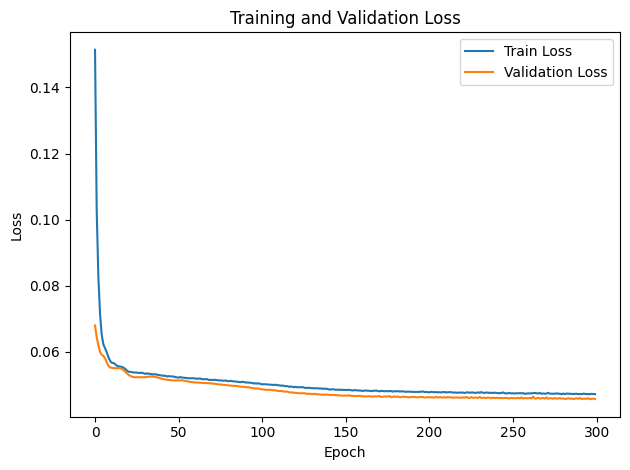

In [9]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


## GAT Regression

In [10]:
in_features = data.x.shape[1]
hidden_features = 16
out_features = 1
num_layers = 2
epochs = 300
lr = 0.01
num_heads = 6

model = GATRegression(in_features, hidden_features, out_features, edge_dim=None, heads=num_heads, num_layers=2)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train_model(model, data, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attributes)[mask]
    loss = criterion(out, data.y[mask].view(-1, 1))
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attributes)[mask]
        mse = criterion(out, data.y[mask].view(-1, 1))
        r2 = r2_score(data.y[mask].view(-1, 1), out)
        mae = mean_absolute_error(out, data.y[mask].view(-1, 1))
        rmse = torch.sqrt(mse)
    return mse.item(), rmse, mae, r2

train_losses = []
val_losses = []
train_maes = []
val_maes = []
val_rmses = []

for epoch in range(epochs):
    train_loss = train_model(model, data, data.train_mask)
    val_mse, val_rmse, val_mae, r2 = evaluate_model(model, data, data.val_mask)

    train_losses.append(train_loss)
    val_losses.append(val_mse)
    val_maes.append(val_mae)
    val_rmses.append(val_rmse)
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_mse:.4f}, Val RMSE: {val_rmse:.4f} Val R2: {r2:.4f}')

test_mse, test_rmse, test_mae, test_r2 = evaluate_model(model, data, data.test_mask)
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}')

Epoch: 001, Train Loss: 0.5561, Val Loss: 1.8209, Val RMSE: 1.3494 Val R2: -29.1580
Epoch: 002, Train Loss: 2.5423, Val Loss: 0.1837, Val RMSE: 0.4286 Val R2: -2.0427
Epoch: 003, Train Loss: 0.3671, Val Loss: 0.2652, Val RMSE: 0.5150 Val R2: -3.3923
Epoch: 004, Train Loss: 0.4221, Val Loss: 0.5988, Val RMSE: 0.7739 Val R2: -8.9179
Epoch: 005, Train Loss: 0.7825, Val Loss: 0.4563, Val RMSE: 0.6755 Val R2: -6.5571
Epoch: 006, Train Loss: 0.5895, Val Loss: 0.2081, Val RMSE: 0.4562 Val R2: -2.4470
Epoch: 007, Train Loss: 0.2950, Val Loss: 0.0837, Val RMSE: 0.2894 Val R2: -0.3867
Epoch: 008, Train Loss: 0.1507, Val Loss: 0.0935, Val RMSE: 0.3057 Val R2: -0.5482
Epoch: 009, Train Loss: 0.1569, Val Loss: 0.1515, Val RMSE: 0.3892 Val R2: -1.5092
Epoch: 010, Train Loss: 0.2212, Val Loss: 0.1744, Val RMSE: 0.4176 Val R2: -1.8881
Epoch: 011, Train Loss: 0.2511, Val Loss: 0.1467, Val RMSE: 0.3830 Val R2: -1.4290
Epoch: 012, Train Loss: 0.2232, Val Loss: 0.1012, Val RMSE: 0.3181 Val R2: -0.6761
Epo

KeyboardInterrupt: 

## TransfomerConv

In [16]:
in_features = data.x.shape[1]
hidden_features = 64
out_features = 1
num_layers = 2
epochs = 150
lr = 0.1
num_heads = 2

model = TransformerRegression(in_features, hidden_features, out_features, edge_dim=2, heads=num_heads)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train_model(model, data, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attributes)[mask]
    loss = criterion(out, data.y[mask].view(-1, 1))
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attributes)[mask]
        mse = criterion(out, data.y[mask].view(-1, 1))
        r2 = r2_score(data.y[mask].view(-1, 1), out)
        mae = mean_absolute_error(out, data.y[mask].view(-1, 1))
        rmse = torch.sqrt(mse)
    return mse.item(), rmse, mae, r2

train_losses = []
val_losses = []
train_maes = []
val_maes = []
val_rmses = []

for epoch in range(epochs):
    train_loss = train_model(model, data, data.train_mask)
    val_mse, val_rmse, val_mae, r2 = evaluate_model(model, data, data.val_mask)

    train_losses.append(train_loss)
    val_losses.append(val_mse)
    val_maes.append(val_mae)
    val_rmses.append(val_rmse)
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_mse:.4f}, Val RMSE: {val_rmse:.4f} Val R2: {r2:.4f}')

test_mse, test_rmse, test_mae, test_r2 = evaluate_model(model, data, data.test_mask)
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}')

Epoch: 001, Train Loss: 1710.4404, Val Loss: 32883.6133, Val RMSE: 181.3384 Val R2: -521872.3368
Epoch: 002, Train Loss: 62878.1914, Val Loss: 694.4125, Val RMSE: 26.3517 Val R2: -11019.5474
Epoch: 003, Train Loss: 1392.1504, Val Loss: 1406.0488, Val RMSE: 37.4973 Val R2: -22313.4406
Epoch: 004, Train Loss: 2522.0806, Val Loss: 3608.8936, Val RMSE: 60.0741 Val R2: -57273.2940
Epoch: 005, Train Loss: 6727.0889, Val Loss: 2542.9031, Val RMSE: 50.4272 Val R2: -40355.6841
Epoch: 006, Train Loss: 4895.0356, Val Loss: 543.6850, Val RMSE: 23.3171 Val R2: -8627.4532
Epoch: 007, Train Loss: 1476.9976, Val Loss: 398.5207, Val RMSE: 19.9630 Val R2: -6323.6500
Epoch: 008, Train Loss: 1805.5237, Val Loss: 1256.2605, Val RMSE: 35.4438 Val R2: -19936.2533
Epoch: 009, Train Loss: 3804.2686, Val Loss: 729.2445, Val RMSE: 27.0045 Val R2: -11572.3410
Epoch: 010, Train Loss: 2577.4172, Val Loss: 95.8467, Val RMSE: 9.7901 Val R2: -1520.1174
Epoch: 011, Train Loss: 1085.4829, Val Loss: 86.2536, Val RMSE: 9.

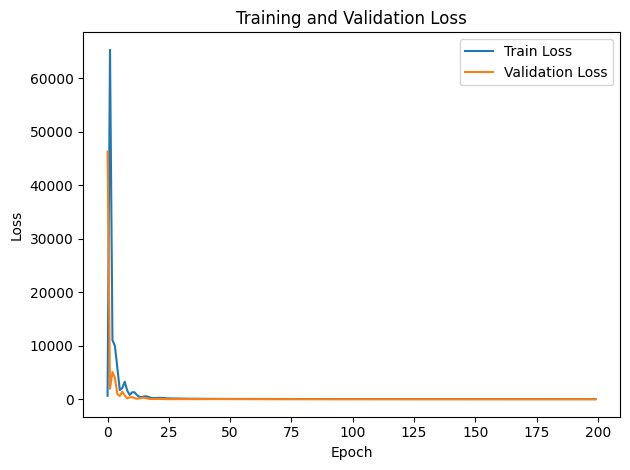

In [10]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

## GATv2

In [12]:
in_features = data.x.shape[1]
hidden_features = 16
out_features = 1
num_layers = 2
epochs = 300
lr = 0.01
num_heads = 6

model = GATv2Regression(in_features, hidden_features, out_features, edge_dim=2, heads=num_heads, num_layers=2)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train_model(model, data, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attributes)[mask]
    loss = criterion(out, data.y[mask].view(-1, 1))
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_attributes)[mask]
        mse = criterion(out, data.y[mask].view(-1, 1))
        r2 = r2_score(data.y[mask].view(-1, 1), out)
        mae = mean_absolute_error(out, data.y[mask].view(-1, 1))
        rmse = torch.sqrt(mse)
    return mse.item(), rmse, mae, r2

train_losses = []
val_losses = []
train_maes = []
val_maes = []
val_rmses = []

for epoch in range(epochs):
    train_loss = train_model(model, data, data.train_mask)
    val_mse, val_rmse, val_mae, r2 = evaluate_model(model, data, data.val_mask)

    train_losses.append(train_loss)
    val_losses.append(val_mse)
    val_maes.append(val_mae)
    val_rmses.append(val_rmse)
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_mse:.4f}, Val RMSE: {val_rmse:.4f} Val R2: {r2:.4f}')

test_mse, test_rmse, test_mae, test_r2 = evaluate_model(model, data, data.test_mask)
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}')

Epoch: 001, Train Loss: 0.3370, Val Loss: 2.1337, Val RMSE: 1.4607 Val R2: -34.3370
Epoch: 002, Train Loss: 2.7946, Val Loss: 0.4203, Val RMSE: 0.6483 Val R2: -5.9610
Epoch: 003, Train Loss: 0.5397, Val Loss: 0.9005, Val RMSE: 0.9489 Val R2: -13.9131
Epoch: 004, Train Loss: 0.9921, Val Loss: 0.7203, Val RMSE: 0.8487 Val R2: -10.9287
Epoch: 005, Train Loss: 0.7518, Val Loss: 0.4639, Val RMSE: 0.6811 Val R2: -6.6838
Epoch: 006, Train Loss: 0.5063, Val Loss: 0.3861, Val RMSE: 0.6214 Val R2: -5.3951
Epoch: 007, Train Loss: 0.4831, Val Loss: 0.2938, Val RMSE: 0.5421 Val R2: -3.8664
Epoch: 008, Train Loss: 0.4089, Val Loss: 0.1701, Val RMSE: 0.4124 Val R2: -1.8172
Epoch: 009, Train Loss: 0.2822, Val Loss: 0.1103, Val RMSE: 0.3321 Val R2: -0.8271
Epoch: 010, Train Loss: 0.2112, Val Loss: 0.1422, Val RMSE: 0.3770 Val R2: -1.3543
Epoch: 011, Train Loss: 0.2256, Val Loss: 0.2022, Val RMSE: 0.4497 Val R2: -2.3490
Epoch: 012, Train Loss: 0.2684, Val Loss: 0.2243, Val RMSE: 0.4736 Val R2: -2.7143
E

KeyboardInterrupt: 

# Classic Regression

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [8]:
data_tensor = torch.cat((data.x, data.y.unsqueeze(1), data.train_mask.unsqueeze(1), data.test_mask.unsqueeze(1)), dim=1)
df_ismt = pd.DataFrame(data_tensor.numpy(), columns=['beautiful','boring','depressing','lively','safe','wealthy',
                                                     'pct_hog40p', 'train', 'test'])

train_split = df_ismt[df_ismt.train == 1]
test_split = df_ismt[df_ismt.test == 1]

X_train, y_train = train_split[['beautiful','boring','depressing','lively','safe','wealthy']], train_split.pct_hog40p
X_test, y_test = test_split[['beautiful','boring','depressing','lively','safe','wealthy']], test_split.pct_hog40p

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Linear Regression

In [10]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

mse_error = mean_squared_error(y_test, y_pred)
mae_error = mean_absolute_error(y_test, y_pred)
r2_score_error = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse_error:.4f}")
print(f"Mean Absolute Error: {mae_error:.4f}")
print(f"R2 Score: {r2_score_error:.4f}")

Mean Squared Error: 0.0564
Mean Absolute Error: 0.2046
R2 Score: 0.1067


## Decision Tree

In [11]:
%%time
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

mse_error = mean_squared_error(y_test, y_pred)
mae_error = mean_absolute_error(y_test, y_pred)
r2_score_error = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse_error:.4f}")
print(f"Mean Absolute Error: {mae_error:.4f}")
print(f"R2 Score: {r2_score_error:.4f}")

Mean Squared Error: 0.0691
Mean Absolute Error: 0.1772
R2 Score: -0.0934
CPU times: total: 3.77 s
Wall time: 13.2 s
